# Шаг 1: Приведем валюты к USD 

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import math
transactions = pq.read_table('transaction_fraud_data.parquet').to_pandas()
exchange_rates = pq.read_table('historical_currency_exchange.parquet').to_pandas()

transactions['date'] = pd.to_datetime(transactions['timestamp']).dt.date
exchange_rates['date'] = pd.to_datetime(exchange_rates['date']).dt.date

melted_rates = exchange_rates.melt(
    id_vars=['date'],
    var_name='currency',
    value_name='exchange_rate'
)
merged = pd.merge(
    transactions,
    melted_rates,
    left_on=['date', 'currency'],
    right_on=['date', 'currency'],
    how='left'
)

merged['amount_USD'] = merged.apply(
    lambda row: row['amount'] / row['exchange_rate'] if row['currency'] != 'USD' else row['amount'],
    axis=1
)

transactions = merged.drop(columns=['date', 'exchange_rate'])

transactions.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,amount_USD
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,619.905757
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,719.506409
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,436.808287
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,434.430069


# Шаг 2: Технические гипотезы
### Гипотеза 1: Мошенничество чаще происходит ночью или в выходные


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\razum\AppData\Local\Temp\ipykernel_12968\3376187024.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(weekday_order, rotation=45)


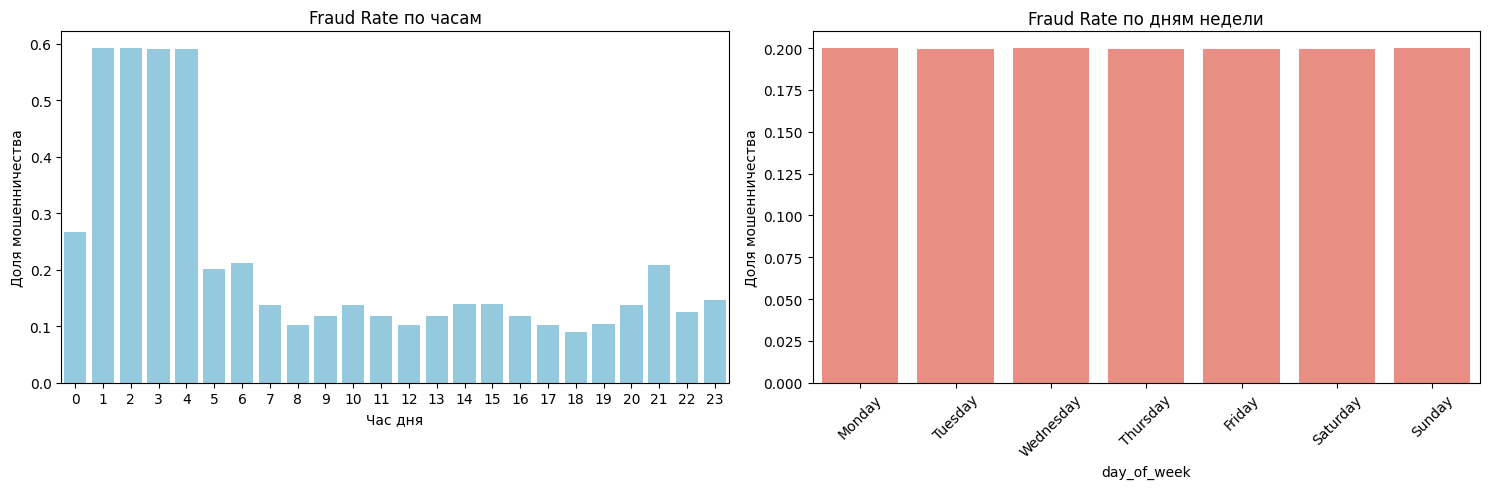

In [3]:
# Гипотеза 1: Мошенничество чаще происходит ночью или в выходные

# Извлечение часа и дня недели
transactions['hour'] = pd.to_datetime(transactions['timestamp']).dt.hour
transactions['day_of_week'] = pd.to_datetime(transactions['timestamp']).dt.day_name()

# Fraud rate по часам
hourly_fraud = transactions.groupby('hour')['is_fraud'].mean().reset_index()

# Fraud rate по дням недели
weekday_fraud = transactions.groupby('day_of_week')['is_fraud'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_fraud['day_of_week'] = pd.Categorical(weekday_fraud['day_of_week'], categories=weekday_order, ordered=True)
weekday_fraud = weekday_fraud.sort_values('day_of_week')

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='hour', y='is_fraud', data=hourly_fraud, ax=ax1, color='skyblue')
ax1.set_title('Fraud Rate по часам')
ax1.set_xlabel('Час дня')
ax1.set_ylabel('Доля мошенничества')

sns.barplot(x='day_of_week', y='is_fraud', data=weekday_fraud, ax=ax2, color='salmon')
ax2.set_title('Fraud Rate по дням недели')
ax2.set_xticklabels(weekday_order, rotation=45)
ax2.set_ylabel('Доля мошенничества')
plt.tight_layout()
plt.show()

Вывод: \
Мошенничество не зависит от дня недели. Основной всплеск мошенничества происходит ночью, с 1 до 4 часов.

### Гипотеза 2: Транзакции вне страны (is_outside_home_country) и в "рисковых" категориях (is_high_risk_vendor) имеют повышенный риск

C:\Users\razum\AppData\Local\Temp\ipykernel_12968\1618792256.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='combination', y='is_fraud', data=risk_flags, palette='viridis')
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

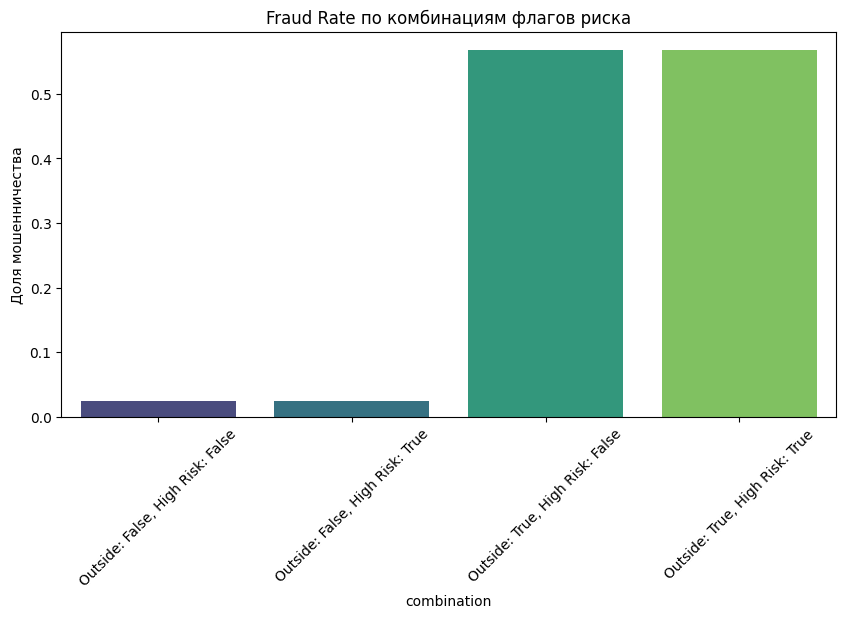

In [6]:
# Группировка по флагам
risk_flags = transactions.groupby(['is_outside_home_country', 'is_high_risk_vendor'])['is_fraud'].mean().reset_index()
risk_flags['combination'] = risk_flags.apply(
    lambda x: f"Outside: {x['is_outside_home_country']}, High Risk: {x['is_high_risk_vendor']}", 
    axis=1
)

# Визуализация
plt.figure(figsize=(10, 5))
sns.barplot(x='combination', y='is_fraud', data=risk_flags, palette='viridis')
plt.title('Fraud Rate по комбинациям флагов риска')
plt.xticks(rotation=45)
plt.ylabel('Доля мошенничества')
plt.show()

Выыод:\
Операции за границей носят повышенную опасность, причем категория операции не имеет значения.

### Гипотеза 3: Аномальная активность в last_hour_activity коррелирует с мошенничеством

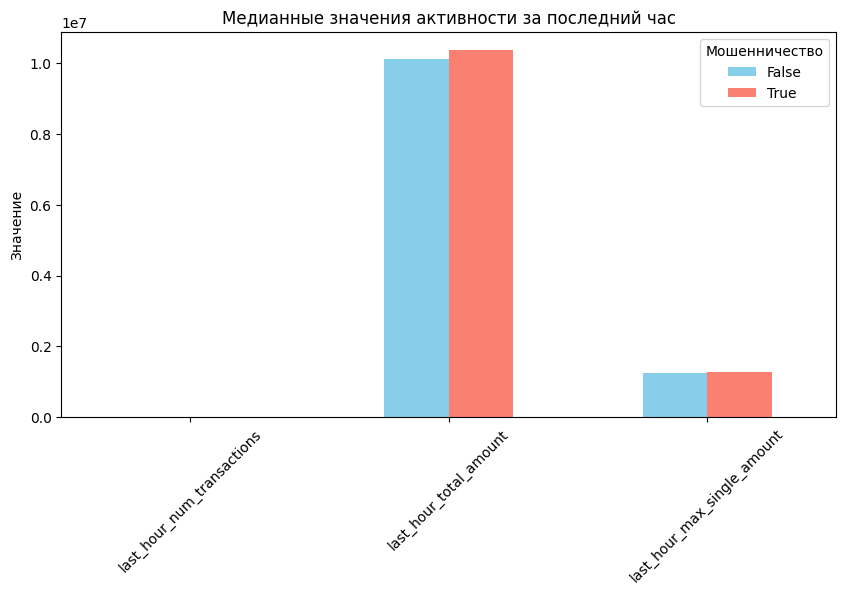

In [8]:
# Распаковка last_hour_activity
for field in ['num_transactions', 'total_amount', 'max_single_amount']:
    transactions[f'last_hour_{field}'] = transactions['last_hour_activity'].apply(lambda x: x[field])

# Сравнение медиан
activity_fields = ['last_hour_num_transactions', 'last_hour_total_amount', 'last_hour_max_single_amount']
fraud_stats = transactions.groupby('is_fraud')[activity_fields].median().T

# Визуализация
fraud_stats.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])
plt.title('Медианные значения активности за последний час')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.legend(title='Мошенничество')
plt.show()

Вывод:\
Гипотеза не верна. 

### Гипотеза 4: Определенные устройства (device) или каналы (channel) уязвимы для атак

C:\Users\razum\AppData\Local\Temp\ipykernel_12968\2797043182.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_fraud', y='device', data=device_fraud, ax=ax1, palette='Blues_d')
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

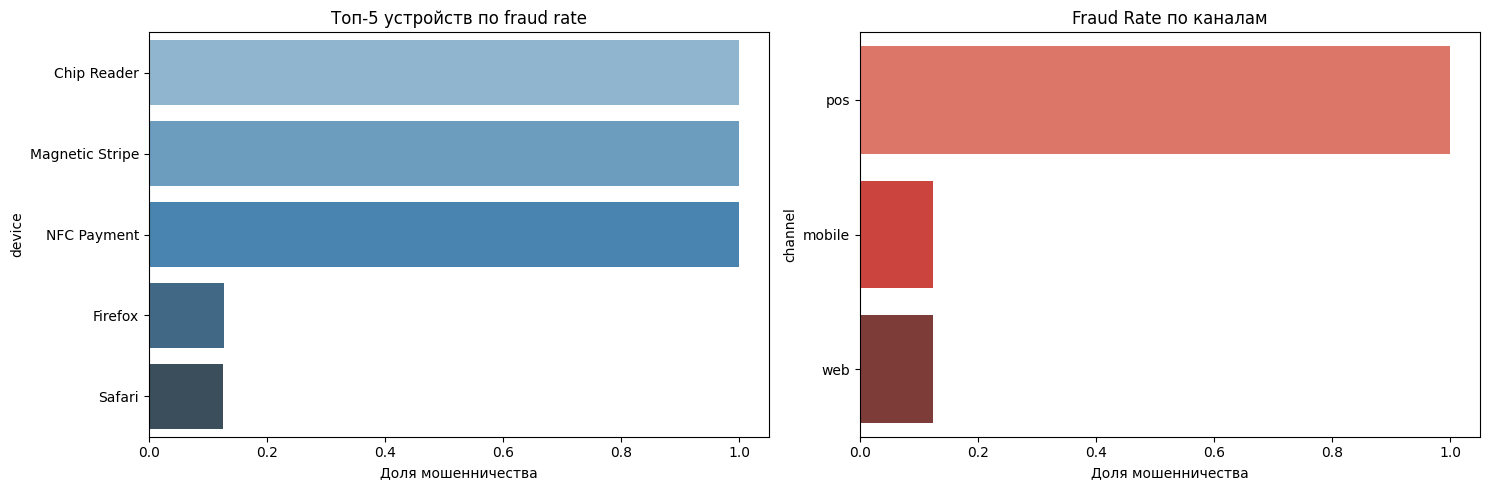

In [10]:
# Топ-5 устройств по fraud rate
device_fraud = transactions.groupby('device')['is_fraud'].mean().sort_values(ascending=False).head(5).reset_index()

# Топ-5 каналов по fraud rate
channel_fraud = transactions.groupby('channel')['is_fraud'].mean().sort_values(ascending=False).reset_index()

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='is_fraud', y='device', data=device_fraud, ax=ax1, palette='Blues_d')
ax1.set_title('Топ-5 устройств по fraud rate')
ax1.set_xlabel('Доля мошенничества')

sns.barplot(x='is_fraud', y='channel', data=channel_fraud, ax=ax2, palette='Reds_d')
ax2.set_title('Fraud Rate по каналам')
ax2.set_xlabel('Доля мошенничества')
plt.tight_layout()
plt.show()

Выыод: \
Устройства Chip Reader, Magnetic Strip, NFC Payment - являются более уязвимыми, чем другие. \
Канал POS является самым уязвимым. 

### Гипотеза 5: Мошеннические транзакции имеют бимодальное распределение суммы (amount_USD)

c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


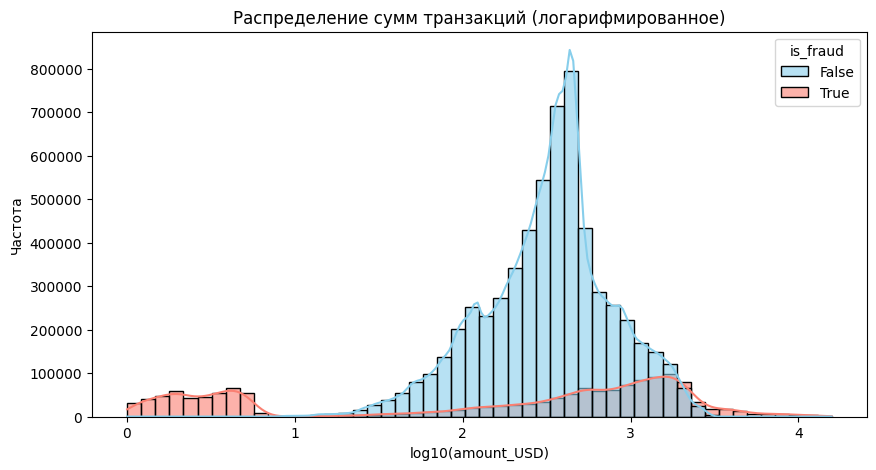

In [11]:
import numpy as np
# Логарифмирование для наглядности
transactions['log_amount'] = np.log10(transactions['amount_USD'] + 1)  # +1 чтобы избежать -inf

# Распределение по классам
plt.figure(figsize=(10, 5))
sns.histplot(
    data=transactions, 
    x='log_amount', 
    hue='is_fraud', 
    bins=50, 
    kde=True, 
    palette=['skyblue', 'salmon'],
    alpha=0.6
)
plt.title('Распределение сумм транзакций (логарифмированное)')
plt.xlabel('log10(amount_USD)')
plt.ylabel('Частота')
plt.show()

Вывод:\
Гипотеза не подтвердилась. Мошеннические транзакции не демонстрируют бимодального распределения.

Основной паттерн: Мошенничество чаще связано с мелкими суммами (тестовые платежи, микротранзакции).


### Гипотеза 6: Различные типы карт могут иметь разную степень мошеннических операций.

C:\Users\razum\AppData\Local\Temp\ipykernel_12968\2414665776.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_fraud', y='card_type', data=fraud_rate, ax=ax1, palette='Blues_d')
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_g

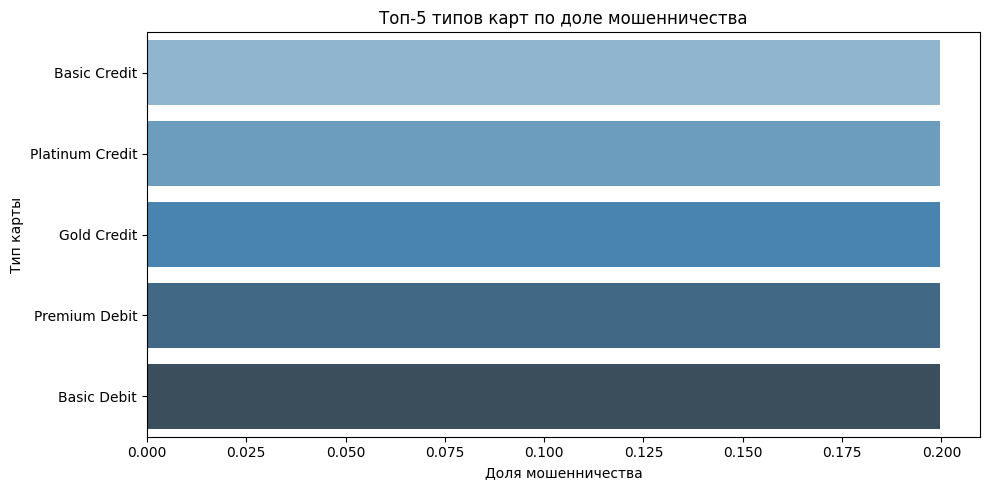

In [26]:
# Вычисление доли мошенничества по типам карт
fraud_rate = transactions.groupby('card_type')['is_fraud'].mean().reset_index()
fraud_rate = fraud_rate.sort_values(by='is_fraud', ascending=False) 

# Создание фигуры и осей
fig, ax1 = plt.subplots(figsize=(10, 5))

# Построение барплота
sns.barplot(x='is_fraud', y='card_type', data=fraud_rate, ax=ax1, palette='Blues_d')

# Настройка заголовка и меток
ax1.set_title('Топ-5 типов карт по доле мошенничества')
ax1.set_xlabel('Доля мошенничества')
ax1.set_ylabel('Тип карты')

# Отображение графика
plt.tight_layout()
plt.show()



Вывод:\
Гипотеза не верна. Тип карты не влияет на степень мошеннических  операций.


# Шаг 3: Продуктовые гипотезы

### Гипотеза 7: Клиенты с низкой "исторической активностью" чаще становятся жертвами мошенничества
Продуктовая идея: \
Если клиент редко совершает транзакции, его аккаунт может быть менее защищен (например, не настроены алерты), что делает его уязвимым.

c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


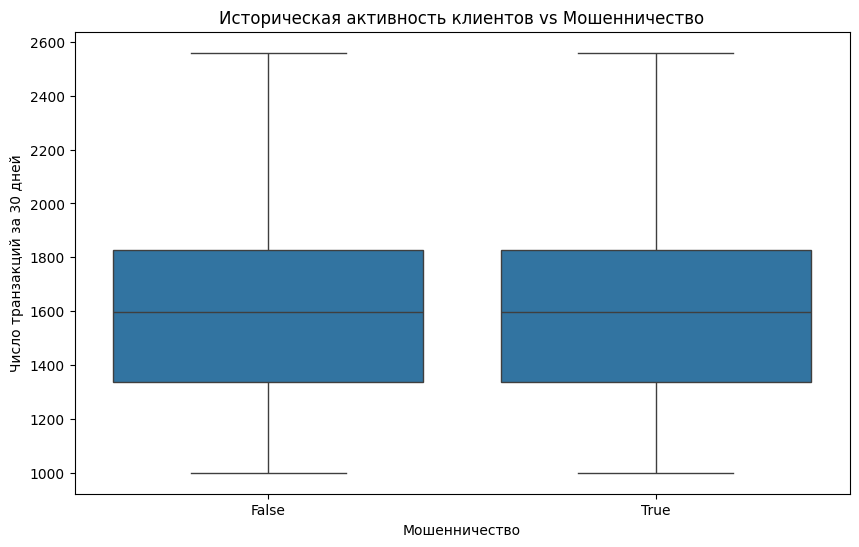

In [ ]:
historical_activity = transactions.groupby('customer_id')['date'].count().reset_index()
historical_activity.columns = ['customer_id', 'total_transactions_last_30d']

# Мержим с исходными данными
merged = pd.merge(transactions, historical_activity, on='customer_id')

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='is_fraud',
    y='total_transactions_last_30d',
    data=merged,
    showfliers=False
)
plt.title('Историческая активность клиентов vs Мошенничество')
plt.xlabel('Мошенничество')
plt.ylabel('Число транзакций за 30 дней')
plt.show()

Вывод: \
Гипотеза не верна


### Гипотеза 8: Клиенты с резким ростом расходов подвержены риску компрометации карты
Продуктовая идея: \
Резкий рост трат может означать, что карта клиента утеряна или данные украдены.

c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


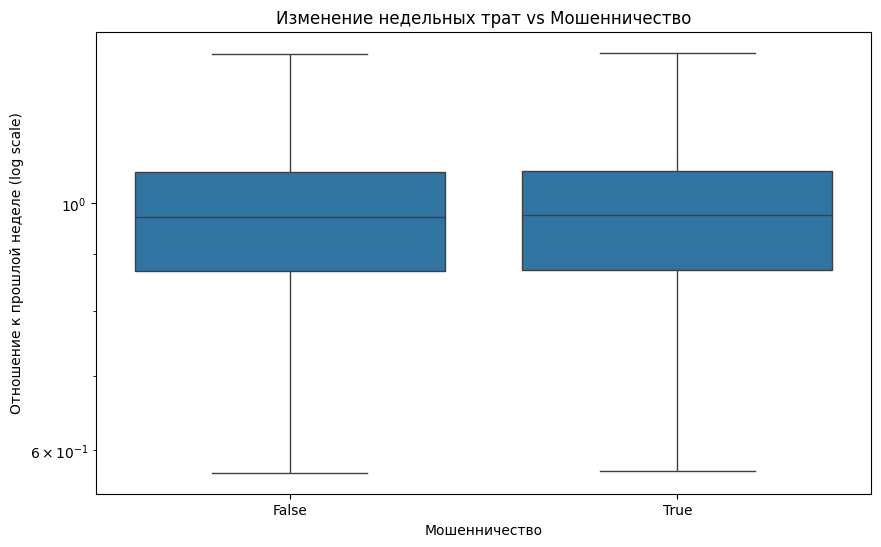

In [30]:
# Считаем средние недельные траты клиента и их изменение
transactions['week'] = pd.to_datetime(transactions['timestamp']).dt.isocalendar().week
weekly_spending = transactions.groupby(['customer_id', 'week'])['amount_USD'].sum().reset_index()

# Изменение трат по неделям
weekly_spending['prev_week_spending'] = weekly_spending.groupby('customer_id')['amount_USD'].shift(1)
weekly_spending['spending_change_ratio'] = weekly_spending['amount_USD'] / weekly_spending['prev_week_spending']

# Мержим с фродом
merged = pd.merge(
    transactions,
    weekly_spending[['customer_id', 'week', 'spending_change_ratio']],
    on=['customer_id', 'week'],
    how='left'
)

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='is_fraud',
    y='spending_change_ratio',
    data=merged[merged['spending_change_ratio'] < 10],  # Обрезаем экстремальные значения
    showfliers=False
)
plt.yscale('log')
plt.title('Изменение недельных трат vs Мошенничество')
plt.xlabel('Мошенничество')
plt.ylabel('Отношение к прошлой неделе (log scale)')
plt.show()

Вывод: \
Гипотеза не верна

### Гипотеза 9: Транзакции без CVC/CVV (например, сохраненные карты) рискованнее
Продуктовая идея: \
Платежи без ввода CVC (например, через Apple Pay) могут быть уязвимы для повторного использования украденных данных.

C:\Users\razum\AppData\Local\Temp\ipykernel_12968\2379028409.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_no_cvc', y='is_fraud', data=cvc_fraud, palette='magma')
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\razum\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

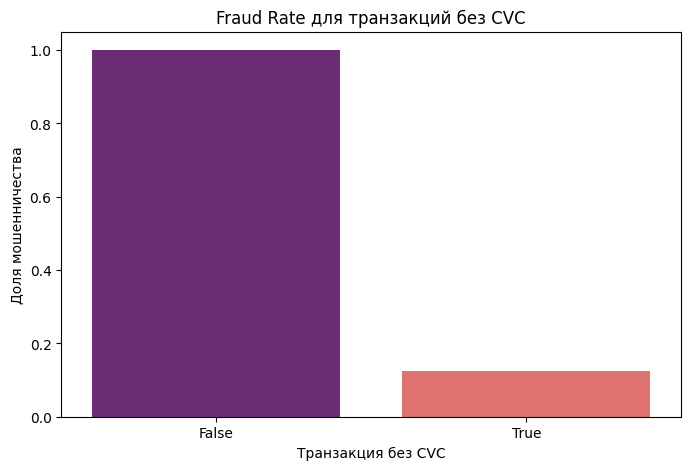

In [31]:
# Создаем флаг "транзакция без CVC" (заглушка: предполагаем, что is_card_present=False — это онлайн-платежи)
transactions['is_no_cvc'] = ~transactions['is_card_present']

# Сравниваем fraud rate
cvc_fraud = transactions.groupby('is_no_cvc')['is_fraud'].mean().reset_index()

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x='is_no_cvc', y='is_fraud', data=cvc_fraud, palette='magma')
plt.title('Fraud Rate для транзакций без CVC')
plt.xlabel('Транзакция без CVC')
plt.ylabel('Доля мошенничества')
plt.show()

На графике доля мошенничества (Fraud Rate) для транзакций без CVC (True) ниже, чем для транзакций с CVC (False), то да — такие транзакции статистически безопаснее.


